# k-Means Clustering

In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.cluster import KMeans
from scipy import stats
import random

## Exploratory Data Analysis

In [29]:
songs = pd.read_csv("songs.csv")
songs.head()

danceability  energy  key  loudness  speechiness  acousticness  \
0         0.244   0.982    8    -5.079        0.109      0.000005   
1         0.368   0.995    6    -4.894        0.183      0.000013   
2         0.227   0.981    6    -5.343        0.145      0.000006   
3         0.265   0.993    8    -4.949        0.173      0.000008   
4         0.348   0.998    2    -5.299        0.208      0.000006   

   instrumentalness  liveness  valence    tempo  
0             0.905    0.0638   0.1960  189.746  
1             0.849    0.1590   0.1430   98.040  
2             0.840    0.0581   0.1240  115.207  
3             0.901    0.1300   0.0857  100.688  
4             0.897    0.1610   0.0391  109.997

In [30]:
songs.describe()

danceability      energy         key    loudness  speechiness  \
count    400.000000  400.000000  400.000000  400.000000   400.000000   
mean       0.474455    0.648439    4.887500   -9.317790     0.134125   
std        0.185507    0.337503    3.510078    6.408121     0.112793   
min        0.111000    0.006460    0.000000  -32.009000     0.025000   
25%        0.317500    0.323750    1.000000  -14.605000     0.039875   
50%        0.500500    0.767000    4.000000   -6.074000     0.088700   
75%        0.624000    0.939500    8.000000   -4.891750     0.208500   
max        0.901000    0.999000   11.000000   -2.403000     0.489000   

       acousticness  instrumentalness    liveness     valence       tempo  
count    400.000000        400.000000  400.000000  400.000000  400.000000  
mean       0.328556          0.380162    0.231836    0.354982  119.033740  
std        0.410574          0.411473    0.221760    0.241950   33.612645  
min        0.000002          0.000000    0.044600    0.028800   41.762000  
25%        0.001010          0.000000    0.098175    0.142750   90.136750  
50%        0.058400          0.081700    0.130000    0.299500  118.023500  
75%        0.887000          0.871500    0.269750    0.543500  142.069500  
max        0.996000          0.983000    0.975000    0.950000  196.106000

In [31]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
danceability        400 non-null float64
energy              400 non-null float64
key                 400 non-null int64
loudness            400 non-null float64
speechiness         400 non-null float64
acousticness        400 non-null float64
instrumentalness    400 non-null float64
liveness            400 non-null float64
valence             400 non-null float64
tempo               400 non-null float64
dtypes: float64(9), int64(1)
memory usage: 31.4 KB


**Remove outliers from song data set using z-scores (z-scores of 3 or more are considered unusual).**

In [32]:
z_scores = stats.zscore(songs)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
filtered_songs = songs[filtered_entries]
filtered_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 399
Data columns (total 10 columns):
danceability        384 non-null float64
energy              384 non-null float64
key                 384 non-null int64
loudness            384 non-null float64
speechiness         384 non-null float64
acousticness        384 non-null float64
instrumentalness    384 non-null float64
liveness            384 non-null float64
valence             384 non-null float64
tempo               384 non-null float64
dtypes: float64(9), int64(1)
memory usage: 33.0 KB


## Genre Classification

### Find Number of Genres

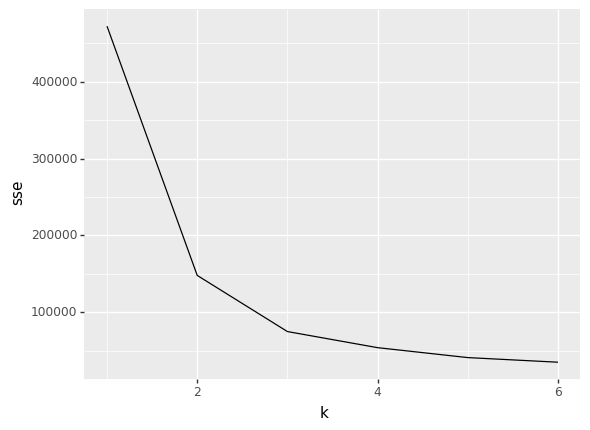

<ggplot: (303671085)>

In [33]:
x = songs.iloc[:,:]
sse = {}
for k in range(1,7):
    km = KMeans(n_clusters=k,max_iter=100)
    km.fit(x)
    sse[k] = km.inertia_
df = pd.DataFrame({"k":list(sse.keys()),"sse":list(sse.values())})
ggplot(df,aes(x="k",y="sse"))+geom_line()

**Using the elbow method, the optimal number of genres is 4 (since the line normalizes after 4).**

### Reduce Number of Properties

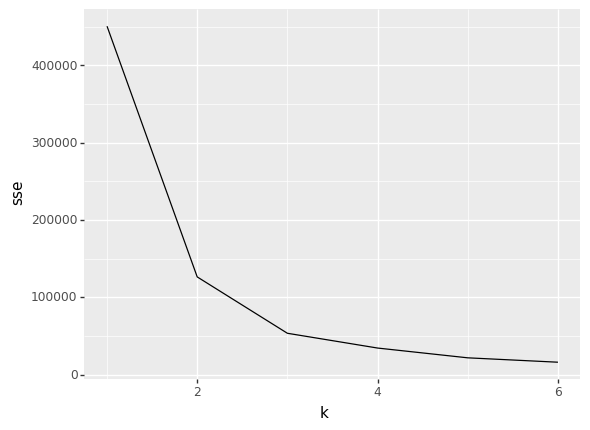

<ggplot: (303671257)>

In [34]:
x = songs.iloc[:,[8,9]]
sse = {}
for k in range(1,7):
    km = KMeans(n_clusters=k,max_iter=100)
    km.fit(x)
    sse[k] = km.inertia_
df = pd.DataFrame({"k":list(sse.keys()),"sse":list(sse.values())})
ggplot(df,aes(x="k",y="sse"))+geom_line()

**This elbow graph is fairly close to the elbow graph of the entire data (4 is still the optimal number of genres). Thus, "valence" and "tempo" are the best predictors in genre.**

### Validation

In order to validate this model, there are 2 different in determining the true genre of each song. For one, can look up each song in the dataset and find out what the genre of each song is by listening to it or looking up the decided genre (this assumes that the genre has already been classified and we have access to the song information). Secondly, we can talk to a domain expert who can classify the genres of each song looking at the data we are given (this may not be as accurate since they will not have access to the song itself). Next, once we have obtained the "true" genre of each song, we can create a training and testing set and compare our songs labeled genre in our test with the actual genre (and compute the accuracy).

## k-Means Algorithm

@param df 2 independent variables from a dataframe

@return df\["cluster"\] Column of clusters for each row in dataframe

In [35]:
def kMeans(df):
    centroids = df.sample(2, replace=False) #initialize 2 centroids to random value
    clusters = pd.DataFrame() #initialize clusters
    max_iter = 20 #maximum number of iterations
    for i in range(max_iter):
        j = 0
        for index, point in centroids.iterrows():
            clusters[j] = (df[centroids.columns] - np.array(point)).pow(2).sum(1).pow(0.5) #clusters equal to distance from centroid to point
            j += 1
        df['cluster'] = clusters.idxmin(axis=1) #creates column cluster equal to centroid with the min distance from a point 
        centroids = pd.DataFrame()
        centroids_frame = df.groupby('cluster').agg(np.mean) #centroid equal to mean of its cluster
        centroids[centroids_frame.columns] = centroids_frame[centroids_frame.columns]
    return df["cluster"] #return cluster column

### Testing

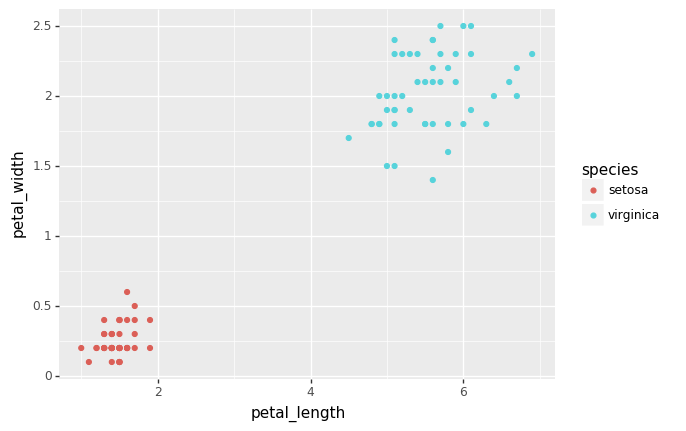

<ggplot: (301751233)>

In [30]:
iris = pd.read_csv("iris.csv")
iris = iris.loc[iris["species"]!="versicolor"]
iris = iris.iloc[:,2:]
ggplot(iris,aes(x="petal_length",y="petal_width",color="species"))+geom_point()

**Original data distribtuion colored by "species"**

**Test k-Means Algorithm on iris data set.**

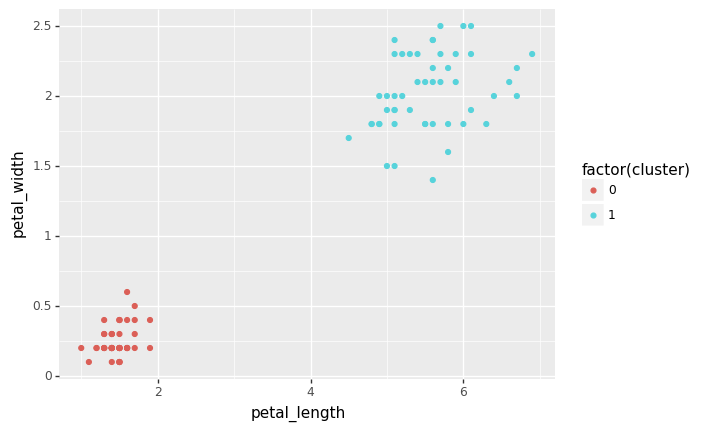

<ggplot: (300664161)>

In [36]:
iris["cluster"] = kMeans(iris.iloc[:,0:1])
ggplot(iris,aes(x="petal_length",y="petal_width",color="factor(cluster)"))+geom_point()

**Distribution of data clustered using k-means algorithm**